# Project 2: Recommendation System - Content-based
### Gemsim, Cosin Similarity

In [1]:
!pip install gensim
!pip install underthesea

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from underthesea import word_tokenize, pos_tag, sent_tokenize
import warnings
from gensim import corpora, models, similarities
import re

In [3]:
import regex

In [4]:
df = pd.read_csv('product_cmt_df.csv')


In [5]:
df = df[['ma_san_pham', 'ten_san_pham', 'gia_ban', 'gia_goc', 'phan_loai', 'mo_ta', 'diem_trung_binh']]

In [6]:
df.duplicated().sum()

20889

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.reset_index(inplace=True, drop = True)

In [9]:
df

,ma_san_pham,ten_san_pham,gia_ban,gia_goc,phan_loai,mo_ta,diem_trung_binh
0,308500015,"Mặt Nạ Naruko Bạch Ngọc Lan Dưỡng Sáng, Săn Ch...",20000,32000.0,1 miếng\n8 miếng\n10 miếng\nTràm trà\nHoa hồng...,Thương hiệu mỹ phẩm NARUKO đến từ Đài Loan nổi...,4.9
1,422216594,Combo 2 Nước Tẩy Trang Bioderma Dành Cho Da Dầ...,730000,1050000.0,"Combo 1000ml\n100ml\n250ml\n500ml\nDa Dầu, Da ...",Nước Tẩy Trang Bioderma bao gồm 2 phân loại: \...,4.9
2,204100075,Nước Tẩy Trang Eucerin Dịu Nhẹ Cho Da Nhạy Cảm...,298000,339000.0,2x400ml\n100ml\n200ml\n400ml,"Nước Tẩy Trang Eucerin Dịu Nhẹ, Cấp Ẩm Cho Da ...",5.0
3,422208977,Sữa Rửa Mặt CeraVe Cho Da Thường Đến Khô 236ml,250000,330000.0,88ml\n236ml\n473ml\nDa khô/Hỗn hợp khô\nDa dầu...,Sữa Rửa Mặt Cerave Sạch Sâu là sản phẩm sữa rử...,4.9
4,345800013,Kem Chống Nắng Some By Mi Nâng Tông Da 50ml,318000,405000.0,NaN,Kem Chống Nắng SOME BY MI Truecica Mineral Cal...,4.3
...,...,...,...,...,...,...,...
681,422204914,Mặt Nạ Garnier Vitamin C & Salicylic Acid Giảm...,35000,39000.0,Cam Yuzu\nVitamin C & Salicylic Acid\nSữa Tươi...,Mặt Nạ Tinh Chất Garnier là dòng mặt nạ dưỡng ...,5.0
682,248700040,"Lotion Naris Cosmetics Dưỡng Ẩm Da, Ngăn Ngừa ...",396000,495000.0,NaN,"Lotion Naris Cosmetics Dưỡng Ẩm Da, Ngăn Ngừa ...",5.0
683,422208920,Kem Dưỡng Bioderma Cấp Ẩm Và Làm Dịu Cho Da Nh...,401000,445000.0,NaN,Kem Dưỡng Bioderma Cấp Ẩm Và Làm Dịu Cho Da Nh...,5.0
684,422207117,Lotion Curél Dưỡng Ẩm Chuyên Sâu Cho Da Lão Hó...,494000,641000.0,NaN,Lotion Curél Dưỡng Ẩm Chuyên Sâu Cho Da Lão Hó...,5.0


### Xử lý cột phan_loai

In [10]:
import re

def process_phan_loai(text):
  # Check if the input is a string
  if isinstance(text, str):
    # Remove numbers using regex
    text = re.sub(r'\d+', '', text)
    # Replace spaces with underscores, but only if not surrounded by underscores
    text = re.sub(r'(?<!_) (?!_)', '_', text)
    # Remove abundant underscores
    text = re.sub(r'_+', '_', text)

    text = re.sub(r'(^|\n)_', r'\1', text) # Capture group for beginning of string or newline

    text = re.sub(r',_([^,]+)', r',\1', text)  # Replace ",_" with "," within comma-separated values

    text = re.sub(r'/', r',', text)

    # Split into lines and process
    lines = text.split('\n')
    processed_lines = ' '.join(lines)
    return processed_lines
  # If not a string, return it as is
  else:
    return text

In [11]:
df['processed_phan_loai'] = df['phan_loai'].apply(process_phan_loai)
df

,ma_san_pham,ten_san_pham,gia_ban,gia_goc,phan_loai,mo_ta,diem_trung_binh,processed_phan_loai
0,308500015,"Mặt Nạ Naruko Bạch Ngọc Lan Dưỡng Sáng, Săn Ch...",20000,32000.0,1 miếng\n8 miếng\n10 miếng\nTràm trà\nHoa hồng...,Thương hiệu mỹ phẩm NARUKO đến từ Đài Loan nổi...,4.9,miếng miếng miếng Tràm_trà Hoa_hồng_nhung Ý_dĩ...
1,422216594,Combo 2 Nước Tẩy Trang Bioderma Dành Cho Da Dầ...,730000,1050000.0,"Combo 1000ml\n100ml\n250ml\n500ml\nDa Dầu, Da ...",Nước Tẩy Trang Bioderma bao gồm 2 phân loại: \...,4.9,"Combo_ml ml ml ml Da_Dầu,Da_Hỗn_Hợp Da_nhạy_cảm"
2,204100075,Nước Tẩy Trang Eucerin Dịu Nhẹ Cho Da Nhạy Cảm...,298000,339000.0,2x400ml\n100ml\n200ml\n400ml,"Nước Tẩy Trang Eucerin Dịu Nhẹ, Cấp Ẩm Cho Da ...",5.0,xml ml ml ml
3,422208977,Sữa Rửa Mặt CeraVe Cho Da Thường Đến Khô 236ml,250000,330000.0,88ml\n236ml\n473ml\nDa khô/Hỗn hợp khô\nDa dầu...,Sữa Rửa Mặt Cerave Sạch Sâu là sản phẩm sữa rử...,4.9,"ml ml ml Da_khô,Hỗn_hợp_khô Da_dầu,Hỗn_hợp_dầu"
4,345800013,Kem Chống Nắng Some By Mi Nâng Tông Da 50ml,318000,405000.0,NaN,Kem Chống Nắng SOME BY MI Truecica Mineral Cal...,4.3,NaN
...,...,...,...,...,...,...,...,...
681,422204914,Mặt Nạ Garnier Vitamin C & Salicylic Acid Giảm...,35000,39000.0,Cam Yuzu\nVitamin C & Salicylic Acid\nSữa Tươi...,Mặt Nạ Tinh Chất Garnier là dòng mặt nạ dưỡng ...,5.0,Cam_Yuzu Vitamin_C_&_Salicylic_Acid Sữa_Tươi_&...
682,248700040,"Lotion Naris Cosmetics Dưỡng Ẩm Da, Ngăn Ngừa ...",396000,495000.0,NaN,"Lotion Naris Cosmetics Dưỡng Ẩm Da, Ngăn Ngừa ...",5.0,NaN
683,422208920,Kem Dưỡng Bioderma Cấp Ẩm Và Làm Dịu Cho Da Nh...,401000,445000.0,NaN,Kem Dưỡng Bioderma Cấp Ẩm Và Làm Dịu Cho Da Nh...,5.0,NaN
684,422207117,Lotion Curél Dưỡng Ẩm Chuyên Sâu Cho Da Lão Hó...,494000,641000.0,NaN,Lotion Curél Dưỡng Ẩm Chuyên Sâu Cho Da Lão Hó...,5.0,NaN


### Xử lý cột mo_ta

In [12]:
STOP_WORD_FILE = 'vietnamese-stopwords.txt'

In [13]:
with open(STOP_WORD_FILE, 'r', encoding='utf-8') as file:
    stop_words = file.read()

stop_words = stop_words.split('\n')

In [14]:
# Loại các ký tự đặc biệt
df.mo_ta = df.mo_ta.str.replace("’",'')
df.mo_ta = df.mo_ta.apply(lambda x: regex.sub(r'\.+', '.', x))

In [15]:
#LOAD TEENCODE
file = open('teencode.txt', 'r', encoding="utf8")
teen_lst = file.read().split('\n')
teen_dict = {}
for line in teen_lst:
    key, value = line.split('\t')
    teen_dict[key] = str(value)
file.close()
###############
#LOAD TRANSLATE ENGLISH -> VNMESE
file = open('english-vnmese.txt', 'r', encoding="utf8")
english_lst = file.read().split('\n')
english_dict = {}
for line in english_lst:
    key, value = line.split('\t')
    english_dict[key] = str(value)
file.close()
################
#LOAD wrong words
file = open('wrong-word.txt', 'r', encoding="utf8")
wrong_lst = file.read().split('\n')
file.close()
#################
#LOAD STOPWORDS
file = open('vietnamese-stopwords.txt', 'r', encoding="utf8")
stopwords_lst = file.read().split('\n')
file.close()

In [16]:
def process_special_word(text):
    # có thể có nhiều từ đặc biệt cần ráp lại với nhau
    new_text = ''
    text_lst = text.split()
    i= 0
    # không, chẳng, chả...
    if 'không' in text_lst:
        while i <= len(text_lst) - 1:
            word = text_lst[i]
            #print(word)
            #print(i)
            if  word == 'không':
                next_idx = i+1
                if next_idx <= len(text_lst) -1:
                    word = word +'_'+ text_lst[next_idx]
                i= next_idx + 1
            else:
                i = i+1
            new_text = new_text + word + ' '
    else:
        new_text = text
    return new_text.strip()

In [17]:
df['mo_ta']=df['mo_ta'].map(lambda x: process_special_word(x))
df.head(10)

,ma_san_pham,ten_san_pham,gia_ban,gia_goc,phan_loai,mo_ta,diem_trung_binh,processed_phan_loai
0,308500015,"Mặt Nạ Naruko Bạch Ngọc Lan Dưỡng Sáng, Săn Ch...",20000,32000.0,1 miếng\n8 miếng\n10 miếng\nTràm trà\nHoa hồng...,Thương hiệu mỹ phẩm NARUKO đến từ Đài Loan nổi...,4.9,miếng miếng miếng Tràm_trà Hoa_hồng_nhung Ý_dĩ...
1,422216594,Combo 2 Nước Tẩy Trang Bioderma Dành Cho Da Dầ...,730000,1050000.0,"Combo 1000ml\n100ml\n250ml\n500ml\nDa Dầu, Da ...",Nước Tẩy Trang Bioderma bao gồm 2 phân loại: N...,4.9,"Combo_ml ml ml ml Da_Dầu,Da_Hỗn_Hợp Da_nhạy_cảm"
2,204100075,Nước Tẩy Trang Eucerin Dịu Nhẹ Cho Da Nhạy Cảm...,298000,339000.0,2x400ml\n100ml\n200ml\n400ml,"Nước Tẩy Trang Eucerin Dịu Nhẹ, Cấp Ẩm Cho Da ...",5.0,xml ml ml ml
3,422208977,Sữa Rửa Mặt CeraVe Cho Da Thường Đến Khô 236ml,250000,330000.0,88ml\n236ml\n473ml\nDa khô/Hỗn hợp khô\nDa dầu...,Sữa Rửa Mặt Cerave Sạch Sâu là sản phẩm sữa rử...,4.9,"ml ml ml Da_khô,Hỗn_hợp_khô Da_dầu,Hỗn_hợp_dầu"
4,345800013,Kem Chống Nắng Some By Mi Nâng Tông Da 50ml,318000,405000.0,NaN,Kem Chống Nắng SOME BY MI Truecica Mineral Cal...,4.3,NaN
5,204100019,Gel Rửa Mặt Eucerin Cho Da Nhờn Mụn 200ml,295000,369000.0,75ml\n200ml\n400ml,Gel Rửa Mặt Cho Da Dầu Mụn Eucerin ProAcne Sol...,5.0,ml ml ml
6,100220035,Dung Dịch Tẩy Da Chết Paula’s Choice 2% BHA 30ml,228000,399000.0,30ml\n118ml,Dung Dịch Loại Bỏ Tế Bào Chết Paulas Choice Sk...,4.9,ml ml
7,204100024,Toner Eucerin Dành Cho Da Nhờn Mụn 200ml,311000,389000.0,100ml\n200ml,Nước Hoa Hồng Dành Cho Da Mụn Eucerin Pro ACNE...,4.8,ml ml
8,422216354,Kem Dưỡng La Roche-Posay Giảm Mụn Hiệu Quả 7.5ml,87000,100000.0,7.5ml\n40ml,Kem Dưỡng La Roche-Posay Effaclar Duo+ M là dò...,4.9,.ml ml
9,100250032,Miếng Dán Mụn Mayan Ultra Thin Spot Plus 12+8 ...,27000,35000.0,20 miếng\n24 miếng,Miếng Dán Mụn Mayancare thuộc thương hiệu Maya...,4.7,miếng miếng


In [18]:
df.head(10)

,ma_san_pham,ten_san_pham,gia_ban,gia_goc,phan_loai,mo_ta,diem_trung_binh,processed_phan_loai
0,308500015,"Mặt Nạ Naruko Bạch Ngọc Lan Dưỡng Sáng, Săn Ch...",20000,32000.0,1 miếng\n8 miếng\n10 miếng\nTràm trà\nHoa hồng...,Thương hiệu mỹ phẩm NARUKO đến từ Đài Loan nổi...,4.9,miếng miếng miếng Tràm_trà Hoa_hồng_nhung Ý_dĩ...
1,422216594,Combo 2 Nước Tẩy Trang Bioderma Dành Cho Da Dầ...,730000,1050000.0,"Combo 1000ml\n100ml\n250ml\n500ml\nDa Dầu, Da ...",Nước Tẩy Trang Bioderma bao gồm 2 phân loại: N...,4.9,"Combo_ml ml ml ml Da_Dầu,Da_Hỗn_Hợp Da_nhạy_cảm"
2,204100075,Nước Tẩy Trang Eucerin Dịu Nhẹ Cho Da Nhạy Cảm...,298000,339000.0,2x400ml\n100ml\n200ml\n400ml,"Nước Tẩy Trang Eucerin Dịu Nhẹ, Cấp Ẩm Cho Da ...",5.0,xml ml ml ml
3,422208977,Sữa Rửa Mặt CeraVe Cho Da Thường Đến Khô 236ml,250000,330000.0,88ml\n236ml\n473ml\nDa khô/Hỗn hợp khô\nDa dầu...,Sữa Rửa Mặt Cerave Sạch Sâu là sản phẩm sữa rử...,4.9,"ml ml ml Da_khô,Hỗn_hợp_khô Da_dầu,Hỗn_hợp_dầu"
4,345800013,Kem Chống Nắng Some By Mi Nâng Tông Da 50ml,318000,405000.0,NaN,Kem Chống Nắng SOME BY MI Truecica Mineral Cal...,4.3,NaN
5,204100019,Gel Rửa Mặt Eucerin Cho Da Nhờn Mụn 200ml,295000,369000.0,75ml\n200ml\n400ml,Gel Rửa Mặt Cho Da Dầu Mụn Eucerin ProAcne Sol...,5.0,ml ml ml
6,100220035,Dung Dịch Tẩy Da Chết Paula’s Choice 2% BHA 30ml,228000,399000.0,30ml\n118ml,Dung Dịch Loại Bỏ Tế Bào Chết Paulas Choice Sk...,4.9,ml ml
7,204100024,Toner Eucerin Dành Cho Da Nhờn Mụn 200ml,311000,389000.0,100ml\n200ml,Nước Hoa Hồng Dành Cho Da Mụn Eucerin Pro ACNE...,4.8,ml ml
8,422216354,Kem Dưỡng La Roche-Posay Giảm Mụn Hiệu Quả 7.5ml,87000,100000.0,7.5ml\n40ml,Kem Dưỡng La Roche-Posay Effaclar Duo+ M là dò...,4.9,.ml ml
9,100250032,Miếng Dán Mụn Mayan Ultra Thin Spot Plus 12+8 ...,27000,35000.0,20 miếng\n24 miếng,Miếng Dán Mụn Mayancare thuộc thương hiệu Maya...,4.7,miếng miếng


In [19]:
def remove_stopword(text, stopwords):
    ###### REMOVE stop words
    document = ' '.join('' if word in stopwords else word for word in text.split())
    #print(document)
    ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

In [20]:
df['mo_ta']=df['mo_ta'].map(lambda x: remove_stopword(x, stopwords_lst))
df.head(10)

,ma_san_pham,ten_san_pham,gia_ban,gia_goc,phan_loai,mo_ta,diem_trung_binh,processed_phan_loai
0,308500015,"Mặt Nạ Naruko Bạch Ngọc Lan Dưỡng Sáng, Săn Ch...",20000,32000.0,1 miếng\n8 miếng\n10 miếng\nTràm trà\nHoa hồng...,Thương hiệu mỹ phẩm NARUKO Đài Loan nổi tiếng ...,4.9,miếng miếng miếng Tràm_trà Hoa_hồng_nhung Ý_dĩ...
1,422216594,Combo 2 Nước Tẩy Trang Bioderma Dành Cho Da Dầ...,730000,1050000.0,"Combo 1000ml\n100ml\n250ml\n500ml\nDa Dầu, Da ...",Nước Tẩy Trang Bioderma bao 2 phân loại: Nước ...,4.9,"Combo_ml ml ml ml Da_Dầu,Da_Hỗn_Hợp Da_nhạy_cảm"
2,204100075,Nước Tẩy Trang Eucerin Dịu Nhẹ Cho Da Nhạy Cảm...,298000,339000.0,2x400ml\n100ml\n200ml\n400ml,"Nước Tẩy Trang Eucerin Dịu Nhẹ, Cấp Ẩm Cho Da ...",5.0,xml ml ml ml
3,422208977,Sữa Rửa Mặt CeraVe Cho Da Thường Đến Khô 236ml,250000,330000.0,88ml\n236ml\n473ml\nDa khô/Hỗn hợp khô\nDa dầu...,Sữa Rửa Mặt Cerave Sạch Sâu sản phẩm sữa rửa m...,4.9,"ml ml ml Da_khô,Hỗn_hợp_khô Da_dầu,Hỗn_hợp_dầu"
4,345800013,Kem Chống Nắng Some By Mi Nâng Tông Da 50ml,318000,405000.0,NaN,Kem Chống Nắng SOME BY MI Truecica Mineral Cal...,4.3,NaN
5,204100019,Gel Rửa Mặt Eucerin Cho Da Nhờn Mụn 200ml,295000,369000.0,75ml\n200ml\n400ml,Gel Rửa Mặt Cho Da Dầu Mụn Eucerin ProAcne Sol...,5.0,ml ml ml
6,100220035,Dung Dịch Tẩy Da Chết Paula’s Choice 2% BHA 30ml,228000,399000.0,30ml\n118ml,Dung Dịch Loại Bỏ Tế Bào Chết Paulas Choice Sk...,4.9,ml ml
7,204100024,Toner Eucerin Dành Cho Da Nhờn Mụn 200ml,311000,389000.0,100ml\n200ml,Nước Hoa Hồng Dành Cho Da Mụn Eucerin Pro ACNE...,4.8,ml ml
8,422216354,Kem Dưỡng La Roche-Posay Giảm Mụn Hiệu Quả 7.5ml,87000,100000.0,7.5ml\n40ml,Kem Dưỡng La Roche-Posay Effaclar Duo+ M dòng ...,4.9,.ml ml
9,100250032,Miếng Dán Mụn Mayan Ultra Thin Spot Plus 12+8 ...,27000,35000.0,20 miếng\n24 miếng,Miếng Dán Mụn Mayancare thương hiệu Mayan sản ...,4.7,miếng miếng


In [21]:
df['processed_mo_ta'] = df['mo_ta'].apply(lambda x: ' '.join(x.split()[:500]))

In [22]:
df['text_description'] = df['processed_phan_loai'].astype(str) + ' ' + df['processed_mo_ta'].astype(str)

In [23]:
pd.set_option('display.max_colwidth', None)
df.head(30)

,ma_san_pham,ten_san_pham,gia_ban,gia_goc,phan_loai,mo_ta,diem_trung_binh,processed_phan_loai,processed_mo_ta,text_description
0,308500015,"Mặt Nạ Naruko Bạch Ngọc Lan Dưỡng Sáng, Săn Chắc Da 30ml",20000,32000.0,1 miếng\n8 miếng\n10 miếng\nTràm trà\nHoa hồng nhung\nÝ dĩ nhân đỏ (bản cũ)\nBạch ngọc lan\nÝ dĩ nhân đỏ (bản mới)\nHoa thủy tiên,"Thương hiệu mỹ phẩm NARUKO Đài Loan nổi tiếng dòng sản phẩm mặt nạ giấy dưỡng da chiết xuất thành thiên nhiên Tràm Trà, Bạch Ngọc Lan, Ý Dĩ Nhân Đỏ, Hoa Hồng, Hoa Thủy Tiên. giúp dưỡng da chuyên sâu hỗ trợ cải thiện vấn đề da nhau. Mặt Nạ NARUKO hiện mặt Hasaki phân lựa chọn: Naruko Raw Jobs Tears Brightening Mask – Ý dĩ nhân đỏ sáng da mới – Mặt nạ se khít lỗ chân lông, sáng da Naruko RJT Pore Minimizing and Brightening Mask – Ý dĩ nhân đỏ – Mặt nạ se khít lỗ chân lông Naruko Narcissus Repairing Mask – Hoa thủy tiên – Mặt nạ tế bào gốc thực vật DNA phục hồi da Naruko Rose and BOTANIC HA Aqua Cubic Hydrating Mask EX – Hoa hồng nhung – Mặt nạ Naruko Tea Tree Shine Control and Blemish Clear Mask – Trà tràm – Mặt nạ trà tràm kiểm soát dầu mụn Naruko Taiwan Magnolia Brightening and Firming Mask EX – Bạch ngọc lan – Mặt nạ dưỡng săn da 1. Mặt Nạ Trà Tràm Kiểm Soát Dầu Và Mụn NARUKO Tea Tree Shine Control and Blemish Clear Mask Mặt nạ trà tràm kiểm soát dầu mụn Naruko Tea Tree Shine Control and Blemish Clear Mask chất liệu than hoạt (miếng mặt nạ màu đen) thành tinh dầu Tràm Trà (Tea Tree), giúp hấp thụ dầu thừa ngăn ngừa mụn, cường kiểm soát bã nhờn trì cân dầu - da, làn da láng mịn, bóng không_tì vết. Làm phân biệt hàng trộn không_? Hàng trộn xuất hoá đơn đỏ (VAT) 100% hàng không_nguồn gốc đó. Tại Hasaki, 100% hàng xuất hoá đơn đỏ hàng không. Nếu nhu cầu hoá đơn đỏ, quý vui 22h ngày. Vì 22h, hệ thống Hasaki động xuất hoá đơn hàng hoá hàng không_đăng kí hoá đơn. Do xuất hoá đơn đỏ 100% đảm bảo 100% hàng Hasaki hàng hãng gốc ràng.",4.9,miếng miếng miếng Tràm_trà Hoa_hồng_nhung Ý_dĩ_nhân_đỏ_(bản_cũ) Bạch_ngọc_lan Ý_dĩ_nhân_đỏ_(bản_mới) Hoa_thủy_tiên,"Thương hiệu mỹ phẩm NARUKO Đài Loan nổi tiếng dòng sản phẩm mặt nạ giấy dưỡng da chiết xuất thành thiên nhiên Tràm Trà, Bạch Ngọc Lan, Ý Dĩ Nhân Đỏ, Hoa Hồng, Hoa Thủy Tiên. giúp dưỡng da chuyên sâu hỗ trợ cải thiện vấn đề da nhau. Mặt Nạ NARUKO hiện mặt Hasaki phân lựa chọn: Naruko Raw Jobs Tears Brightening Mask – Ý dĩ nhân đỏ sáng da mới – Mặt nạ se khít lỗ chân lông, sáng da Naruko RJT Pore Minimizing and Brightening Mask – Ý dĩ nhân đỏ – Mặt nạ se khít lỗ chân lông Naruko Narcissus Repairing Mask – Hoa thủy tiên – Mặt nạ tế bào gốc thực vật DNA phục hồi da Naruko Rose and BOTANIC HA Aqua Cubic Hydrating Mask EX – Hoa hồng nhung – Mặt nạ Naruko Tea Tree Shine Control and Blemish Clear Mask – Trà tràm – Mặt nạ trà tràm kiểm soát dầu mụn Naruko Taiwan Magnolia Brightening and Firming Mask EX – Bạch ngọc lan – Mặt nạ dưỡng săn da 1. Mặt Nạ Trà Tràm Kiểm Soát Dầu Và Mụn NARUKO Tea Tree Shine Control and Blemish Clear Mask Mặt nạ trà tràm kiểm soát dầu mụn Naruko Tea Tree Shine Control and Blemish Clear Mask chất liệu than hoạt (miếng mặt nạ màu đen) thành tinh dầu Tràm Trà (Tea Tree), giúp hấp thụ dầu thừa ngăn ngừa mụn, cường kiểm soát bã nhờn trì cân dầu - da, làn da láng mịn, bóng không_tì vết. Làm phân biệt hàng trộn không_? Hàng trộn xuất hoá đơn đỏ (VAT) 100% hàng không_nguồn gốc đó. Tại Hasaki, 100% hàng xuất hoá đơn đỏ hàng không. Nếu nhu cầu hoá đơn đỏ, quý vui 22h ngày. Vì 22h, hệ thống Hasaki động xuất hoá đơn hàng hoá hàng không_đăng kí hoá đơn. Do xuất hoá đơn đỏ 100% đảm bảo 100% hàng Hasaki hàng hãng gốc ràng.","miếng miếng miếng Tràm_trà Hoa_hồng_nhung Ý_dĩ_nhân_đỏ_(bản_cũ) Bạch_ngọc_lan Ý_dĩ_nhân_đỏ_(bản_mới) Hoa_thủy_tiên Thương hiệu mỹ phẩm NARUKO Đài Loan nổi tiếng dòng sản phẩm mặt nạ giấy dưỡng da chiết xuất thành thiên nhiên Tràm Trà, Bạch Ngọc Lan, Ý Dĩ Nhân Đỏ, Hoa Hồng, Hoa Thủy Tiên. giúp dưỡng da chuyên sâu hỗ trợ cải thiện vấn đề da nhau. Mặt Nạ NARUKO hiện mặt Hasaki phân lựa chọn: Naruko Raw Jobs Tears Br

In [24]:
# word_tokenize
df["Content"]=df["text_description"].apply(lambda x: word_tokenize(x, format="text"))

In [25]:
pd.set_option('display.max_colwidth', None)
df.head(30)

,ma_san_pham,ten_san_pham,gia_ban,gia_goc,phan_loai,mo_ta,diem_trung_binh,processed_phan_loai,processed_mo_ta,text_description,Content
0,308500015,"Mặt Nạ Naruko Bạch Ngọc Lan Dưỡng Sáng, Săn Chắc Da 30ml",20000,32000.0,1 miếng\n8 miếng\n10 miếng\nTràm trà\nHoa hồng nhung\nÝ dĩ nhân đỏ (bản cũ)\nBạch ngọc lan\nÝ dĩ nhân đỏ (bản mới)\nHoa thủy tiên,"Thương hiệu mỹ phẩm NARUKO Đài Loan nổi tiếng dòng sản phẩm mặt nạ giấy dưỡng da chiết xuất thành thiên nhiên Tràm Trà, Bạch Ngọc Lan, Ý Dĩ Nhân Đỏ, Hoa Hồng, Hoa Thủy Tiên. giúp dưỡng da chuyên sâu hỗ trợ cải thiện vấn đề da nhau. Mặt Nạ NARUKO hiện mặt Hasaki phân lựa chọn: Naruko Raw Jobs Tears Brightening Mask – Ý dĩ nhân đỏ sáng da mới – Mặt nạ se khít lỗ chân lông, sáng da Naruko RJT Pore Minimizing and Brightening Mask – Ý dĩ nhân đỏ – Mặt nạ se khít lỗ chân lông Naruko Narcissus Repairing Mask – Hoa thủy tiên – Mặt nạ tế bào gốc thực vật DNA phục hồi da Naruko Rose and BOTANIC HA Aqua Cubic Hydrating Mask EX – Hoa hồng nhung – Mặt nạ Naruko Tea Tree Shine Control and Blemish Clear Mask – Trà tràm – Mặt nạ trà tràm kiểm soát dầu mụn Naruko Taiwan Magnolia Brightening and Firming Mask EX – Bạch ngọc lan – Mặt nạ dưỡng săn da 1. Mặt Nạ Trà Tràm Kiểm Soát Dầu Và Mụn NARUKO Tea Tree Shine Control and Blemish Clear Mask Mặt nạ trà tràm kiểm soát dầu mụn Naruko Tea Tree Shine Control and Blemish Clear Mask chất liệu than hoạt (miếng mặt nạ màu đen) thành tinh dầu Tràm Trà (Tea Tree), giúp hấp thụ dầu thừa ngăn ngừa mụn, cường kiểm soát bã nhờn trì cân dầu - da, làn da láng mịn, bóng không_tì vết. Làm phân biệt hàng trộn không_? Hàng trộn xuất hoá đơn đỏ (VAT) 100% hàng không_nguồn gốc đó. Tại Hasaki, 100% hàng xuất hoá đơn đỏ hàng không. Nếu nhu cầu hoá đơn đỏ, quý vui 22h ngày. Vì 22h, hệ thống Hasaki động xuất hoá đơn hàng hoá hàng không_đăng kí hoá đơn. Do xuất hoá đơn đỏ 100% đảm bảo 100% hàng Hasaki hàng hãng gốc ràng.",4.9,miếng miếng miếng Tràm_trà Hoa_hồng_nhung Ý_dĩ_nhân_đỏ_(bản_cũ) Bạch_ngọc_lan Ý_dĩ_nhân_đỏ_(bản_mới) Hoa_thủy_tiên,"Thương hiệu mỹ phẩm NARUKO Đài Loan nổi tiếng dòng sản phẩm mặt nạ giấy dưỡng da chiết xuất thành thiên nhiên Tràm Trà, Bạch Ngọc Lan, Ý Dĩ Nhân Đỏ, Hoa Hồng, Hoa Thủy Tiên. giúp dưỡng da chuyên sâu hỗ trợ cải thiện vấn đề da nhau. Mặt Nạ NARUKO hiện mặt Hasaki phân lựa chọn: Naruko Raw Jobs Tears Brightening Mask – Ý dĩ nhân đỏ sáng da mới – Mặt nạ se khít lỗ chân lông, sáng da Naruko RJT Pore Minimizing and Brightening Mask – Ý dĩ nhân đỏ – Mặt nạ se khít lỗ chân lông Naruko Narcissus Repairing Mask – Hoa thủy tiên – Mặt nạ tế bào gốc thực vật DNA phục hồi da Naruko Rose and BOTANIC HA Aqua Cubic Hydrating Mask EX – Hoa hồng nhung – Mặt nạ Naruko Tea Tree Shine Control and Blemish Clear Mask – Trà tràm – Mặt nạ trà tràm kiểm soát dầu mụn Naruko Taiwan Magnolia Brightening and Firming Mask EX – Bạch ngọc lan – Mặt nạ dưỡng săn da 1. Mặt Nạ Trà Tràm Kiểm Soát Dầu Và Mụn NARUKO Tea Tree Shine Control and Blemish Clear Mask Mặt nạ trà tràm kiểm soát dầu mụn Naruko Tea Tree Shine Control and Blemish Clear Mask chất liệu than hoạt (miếng mặt nạ màu đen) thành tinh dầu Tràm Trà (Tea Tree), giúp hấp thụ dầu thừa ngăn ngừa mụn, cường kiểm soát bã nhờn trì cân dầu - da, làn da láng mịn, bóng không_tì vết. Làm phân biệt hàng trộn không_? Hàng trộn xuất hoá đơn đỏ (VAT) 100% hàng không_nguồn gốc đó. Tại Hasaki, 100% hàng xuất hoá đơn đỏ hàng không. Nếu nhu cầu hoá đơn đỏ, quý vui 22h ngày. Vì 22h, hệ thống Hasaki động xuất hoá đơn hàng hoá hàng không_đăng kí hoá đơn. Do xuất hoá đơn đỏ 100% đảm bảo 100% hàng Hasaki hàng hãng gốc ràng.","miếng miếng miếng Tràm_trà Hoa_hồng_nhung Ý_dĩ_nhân_đỏ_(bản_cũ) Bạch_ngọc_lan Ý_dĩ_nhân_đỏ_(bản_mới) Hoa_thủy_tiên Thương hiệu mỹ phẩm NARUKO Đài Loan nổi tiếng dòng sản phẩm mặt nạ giấy dưỡng da chiết xuất thành thiên nhiên Tràm Trà, Bạch Ngọc Lan, Ý Dĩ Nhân Đỏ, Hoa Hồng, Hoa Thủy Tiên. giúp dưỡng da chuyên sâu hỗ trợ cải thiện vấn đề da nhau. Mặt Nạ NARUKO hiện mặt Hasaki phân lựa chọn: Naruko Raw Jobs 

In [26]:
# Tokenize(split) the sentences into words
content_gem = [[text for text in x.split()] for x in df.Content]

In [27]:
len(content_gem)

686

In [28]:
content_gem[:1]

[['miếng',
  'miếng',
  'miếng',
  'Tràm_trà',
  'Hoa_hồng_nhung_Ý_dĩ_nhân_đỏ_',
  '(',
  'bản_cũ',
  ')',
  'Bạch_ngọc_lan_Ý_dĩ_nhân_đỏ_',
  '(',
  'bản_mới',
  ')',
  'Hoa_thủy_tiên_Thương_hiệu',
  'mỹ_phẩm',
  'NARUKO',
  'Đài_Loan',
  'nổi_tiếng',
  'dòng',
  'sản_phẩm',
  'mặt_nạ',
  'giấy_dưỡng',
  'da_chiết',
  'xuất_thành',
  'thiên_nhiên',
  'Tràm_Trà',
  ',',
  'Bạch_Ngọc_Lan',
  ',',
  'Ý',
  'Dĩ_Nhân_Đỏ',
  ',',
  'Hoa_Hồng',
  ',',
  'Hoa_Thủy_Tiên',
  '.',
  'giúp',
  'dưỡng',
  'da',
  'chuyên_sâu',
  'hỗ_trợ',
  'cải_thiện',
  'vấn_đề',
  'da',
  'nhau',
  '.',
  'Mặt_Nạ',
  'NARUKO',
  'hiện',
  'mặt',
  'Hasaki_phân',
  'lựa_chọn',
  ':',
  'Naruko_Raw',
  'Jobs_Tears',
  'Brightening_Mask',
  '–',
  'Ý_dĩ_nhân',
  'đỏ',
  'sáng',
  'da',
  'mới',
  '–',
  'Mặt_nạ',
  'se',
  'khít',
  'lỗ',
  'chân_lông',
  ',',
  'sáng',
  'da',
  'Naruko_RJT',
  'Pore_Minimizing',
  'and_Brightening',
  'Mask',
  '–',
  'Ý_dĩ',
  'nhân',
  'đỏ',
  '–',
  'Mặt_nạ',
  'se',
  'khít',

In [29]:
import re

In [30]:
# Tiền xử lý dữ liệu
content_gem_re = [[re.sub('[0-9]+','', e) for e in text] for text in content_gem]
content_gem_re = [[t.lower() for t in text if not t in ['', ' ', ',', '.', '...', '-',':', ';', '?', '%', '(', ')', '+', '/', "'", '&', '*', '"', "_"]] for text in  content_gem_re] # kiểm tra nội dung và đưa vào các ký tự đặc biệt
content_gem_re = [[t for t in text if not t in stop_words] for text in content_gem_re] # stopword

In [31]:
content_gem_re[:1]

[['miếng',
  'miếng',
  'miếng',
  'tràm_trà',
  'hoa_hồng_nhung_ý_dĩ_nhân_đỏ_',
  'bản_cũ',
  'bạch_ngọc_lan_ý_dĩ_nhân_đỏ_',
  'bản_mới',
  'hoa_thủy_tiên_thương_hiệu',
  'mỹ_phẩm',
  'naruko',
  'đài_loan',
  'nổi_tiếng',
  'dòng',
  'sản_phẩm',
  'mặt_nạ',
  'giấy_dưỡng',
  'da_chiết',
  'xuất_thành',
  'thiên_nhiên',
  'tràm_trà',
  'bạch_ngọc_lan',
  'dĩ_nhân_đỏ',
  'hoa_hồng',
  'hoa_thủy_tiên',
  'giúp',
  'dưỡng',
  'da',
  'chuyên_sâu',
  'cải_thiện',
  'da',
  'mặt_nạ',
  'naruko',
  'hiện',
  'mặt',
  'hasaki_phân',
  'lựa_chọn',
  'naruko_raw',
  'jobs_tears',
  'brightening_mask',
  '–',
  'ý_dĩ_nhân',
  'đỏ',
  'da',
  '–',
  'mặt_nạ',
  'se',
  'khít',
  'lỗ',
  'chân_lông',
  'da',
  'naruko_rjt',
  'pore_minimizing',
  'and_brightening',
  'mask',
  '–',
  'ý_dĩ',
  'nhân',
  'đỏ',
  '–',
  'mặt_nạ',
  'se',
  'khít',
  'lỗ',
  'chân',
  'lông',
  'naruko_narcissus',
  'repairing_mask',
  '–',
  'hoa',
  'thủy_tiên',
  '–',
  'mặt_nạ',
  'tế_bào',
  'gốc',
  'thực_vật'

In [32]:
product_stop_words = 'product_stop_words.csv'

In [33]:
with open(product_stop_words, 'r', encoding='utf-8') as file:
    product_stop_words = file.read()

product_stop_words = product_stop_words.split('\n')

In [34]:
content_gem_re = [[t.lower() for t in text if not t in ['_','–']] for text in  content_gem_re] # kiểm tra nội dung và đưa vào các ký tự đặc biệt
content_gem_re = [[t for t in text if not t in product_stop_words] for text in content_gem_re] # stopword

In [35]:
# Obtain the number of features based on dictionary: Use corpora.Dictionary
dictionary = corpora.Dictionary(content_gem_re)

In [36]:
# List of features in dictionary
dictionary.token2id

{'and_blemish': 0,
 'and_botanic': 1,
 'and_brightening': 2,
 'and_firming': 3,
 'brightening_mask': 4,
 'bã': 5,
 'bóng': 6,
 'bạch_ngọc': 7,
 'bạch_ngọc_lan': 8,
 'bạch_ngọc_lan_ý_dĩ_nhân_đỏ_': 9,
 'bản_cũ': 10,
 'bản_mới': 11,
 'chuyên_sâu': 12,
 'chân': 13,
 'chân_lông': 14,
 'clear_mask': 15,
 'cubic_hydrating': 16,
 'cân': 17,
 'cường': 18,
 'cải_thiện': 19,
 'da': 20,
 'da_chiết': 21,
 'dna_phục_hồi': 22,
 'dòng': 23,
 'dĩ_nhân_đỏ': 24,
 'dưỡng': 25,
 'dầu': 26,
 'dầu_và': 27,
 'giúp': 28,
 'giấy_dưỡng': 29,
 'gốc': 30,
 'ha_aqua': 31,
 'hasaki': 32,
 'hasaki_phân': 33,
 'hasaki_động': 34,
 'hiện': 35,
 'hoa': 36,
 'hoa_hồng': 37,
 'hoa_hồng_nhung_ý_dĩ_nhân_đỏ_': 38,
 'hoa_thủy_tiên': 39,
 'hoa_thủy_tiên_thương_hiệu': 40,
 'hàng_không': 41,
 'hàng_trộn': 42,
 'hấp_thụ': 43,
 'hệ_thống': 44,
 'jobs_tears': 45,
 'khít': 46,
 'không_': 47,
 'không_nguồn': 48,
 'không_tì_vết': 49,
 'không_đăng_kí': 50,
 'kiểm_soát': 51,
 'lan': 52,
 'làn': 53,
 'láng_mịn': 54,
 'lông': 55,
 'lỗ': 56

In [37]:
# Numbers of features (word) in dictionary
feature_cnt = len(dictionary.token2id)

In [38]:
feature_cnt

4204

In [39]:
# Obtain corpus based on dictionary (dense matrix)
corpus = [dictionary.doc2bow(text) for text in content_gem_re]

In [40]:
corpus[0] # id, so lan xuat hien cua token trong van ban/ san pham

[(0, 3),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 3),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 8),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 4),
 (27, 1),
 (28, 2),
 (29, 1),
 (30, 3),
 (31, 1),
 (32, 2),
 (33, 1),
 (34, 1),
 (35, 1),
 (36, 1),
 (37, 2),
 (38, 1),
 (39, 1),
 (40, 1),
 (41, 1),
 (42, 1),
 (43, 1),
 (44, 1),
 (45, 1),
 (46, 2),
 (47, 1),
 (48, 1),
 (49, 1),
 (50, 1),
 (51, 4),
 (52, 1),
 (53, 1),
 (54, 1),
 (55, 1),
 (56, 2),
 (57, 1),
 (58, 1),
 (59, 2),
 (60, 4),
 (61, 1),
 (62, 1),
 (63, 10),
 (64, 1),
 (65, 3),
 (66, 1),
 (67, 1),
 (68, 4),
 (69, 1),
 (70, 1),
 (71, 1),
 (72, 1),
 (73, 1),
 (74, 1),
 (75, 1),
 (76, 1),
 (77, 1),
 (78, 1),
 (79, 1),
 (80, 1),
 (81, 1),
 (82, 1),
 (83, 1),
 (84, 2),
 (85, 3),
 (86, 1),
 (87, 1),
 (88, 4),
 (89, 1),
 (90, 1),
 (91, 1),
 (92, 1),
 (93, 1),
 (94, 1),
 (95, 1),
 (96, 2),
 (97, 2),
 (98, 2),
 (99, 3),
 (100, 1)

In [41]:
# Use TF-IDF Model to process corpus, obtaining index
tfidf = models.TfidfModel(corpus)
# tính toán sự tương tự trong ma trận thưa thớt
index = similarities.SparseMatrixSimilarity(tfidf[corpus],
                                            num_features = feature_cnt)
# ma tran: n x n

In [42]:
df_1 = pd.DataFrame(index)
df_1

,0,1,2,3,4,5,6,7,8,9,...,676,677,678,679,680,681,682,683,684,685
0,1.000000,0.002846,0.002134,0.006001,0.004956,0.017974,0.036675,0.057356,0.038162,0.076033,...,0.082329,0.001209,0.002264,0.000628,0.043594,0.032055,0.015399,0.011346,0.013528,0.000952
1,0.002846,1.000000,0.161115,0.030600,0.015449,0.085155,0.048089,0.058395,0.026604,0.002285,...,0.006464,0.007630,0.002553,0.017259,0.006720,0.000365,0.016864,0.050475,0.011932,0.031923
2,0.002134,0.161115,1.000000,0.040909,0.004677,0.076573,0.010076,0.091452,0.026682,0.006863,...,0.001427,0.005910,0.000085,0.006945,0.002183,0.001302,0.058943,0.023557,0.003830,0.029920
3,0.006001,0.030600,0.040909,1.000000,0.003002,0.044196,0.008465,0.022902,0.020082,0.001992,...,0.001132,0.004260,0.024012,0.145853,0.007339,0.009498,0.019898,0.012031,0.004067,0.016061
4,0.004956,0.015449,0.004677,0.003002,1.000000,0.013950,0.039369,0.017218,0.027181,0.010543,...,0.006481,0.001273,0.010907,0.028427,0.028250,0.001231,0.076415,0.033160,0.044821,0.031405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,0.032055,0.000365,0.001302,0.009498,0.001231,0.004781,0.017407,0.002313,0.013483,0.008128,...,0.012284,0.002702,0.002223,0.000068,0.008071,1.000000,0.009980,0.010989,0.000239,0.006701
682,0.015399,0.016864,0.058943,0.019898,0.076415,0.054426,0.069161,0.014713,0.018539,0.002361,...,0.020221,0.019913,0.005645,0.087942,0.033895,0.009980,1.000000,0.012831,0.203133,0.023366
683,0.011346,0.050475,0.023557,0.012031,0.033160,0.023039,0.003798,0.027191,0.035932,0.000628,...,0.033037,0.002527,0.028367,0.010664,0.001086,0.010989,0.012831,1.000000,0.005440,0.029115
684,0.013528,0.011932,0.003830,0.004067,0.044821,0.006982,0.030442,0.002366,0.023528,0.006887,...,0.013378,0.006798,0.012227,0.003788,0.017021,0.000239,0.203133,0.005440,1.000000,0.001065


In [43]:
import time

top_n = 5

product_code = 422216594

start_time = time.time()

product_index = df.index[df['ma_san_pham'] == product_code][0]
view_content = content_gem_re[product_index]
# Convert search words into Sparse Vectors
kw_vector = dictionary.doc2bow(view_content)
# similarity calculation
sim = index[tfidf[kw_vector]]
# order by sim
sim_sort = sorted(enumerate(sim), key=lambda item: -item[1])

similar_product_indices = [i[0] for i in sim_sort[0:top_n + 1]]  # Exclude the input product itself
similar_product_codes = df.iloc[similar_product_indices]



end_time = time.time()
elapsed_time = end_time - start_time

similar_product_codes


,ma_san_pham,ten_san_pham,gia_ban,gia_goc,phan_loai,mo_ta,diem_trung_binh,processed_phan_loai,processed_mo_ta,text_description,Content
1,422216594,Combo 2 Nước Tẩy Trang Bioderma Dành Cho Da Dầu & Hỗn Hợp 500ml,730000,1050000.0,"Combo 1000ml\n100ml\n250ml\n500ml\nDa Dầu, Da Hỗn Hợp\nDa nhạy cảm","Nước Tẩy Trang Bioderma bao 2 phân loại: Nước Tẩy Trang Bioderma Dành Cho Da Nhạy Cảm: 100ml; 250ml; 500ml; Combo 1000ml (2x500ml) Nước Tẩy Trang Bioderma Dành Cho Da Dầu & Hỗn Hợp: 100ml; 250ml; 500ml; Combo 1000ml (2x500ml) THÔNG TIN SẢN PHẨM 1. Nước Tẩy Trang Bioderma Dành Cho Da Nhạy Cảm Dành Cho Da Nhạy Cảm Bioderma Sensibio H2O sản phẩm tẩy trang công nghệ Micellar đầu tiên giới, thương hiệu dược mỹ phẩm Bioderma nổi tiếng Pháp phát minh. Dung dịch giúp sạch sâu da lớp trang chóng rửa nước. Công thức dịu nhẹ, không_kích ứng, không_gây khô căng da, đặc biệt phù hợp làn da nhạy cảm. Làm phân biệt hàng trộn không_? Hàng trộn xuất hoá đơn đỏ (VAT) 100% hàng không_nguồn gốc đó. Tại Hasaki, 100% hàng xuất hoá đơn đỏ hàng không. Nếu nhu cầu hoá đơn đỏ, quý vui 22h ngày. Vì 22h, hệ thống Hasaki động xuất hoá đơn hàng hoá hàng không_đăng kí hoá đơn. Do xuất hoá đơn đỏ 100% đảm bảo 100% hàng Hasaki hàng hãng gốc ràng.",4.9,"Combo_ml ml ml ml Da_Dầu,Da_Hỗn_Hợp Da_nhạy_cảm","Nước Tẩy Trang Bioderma bao 2 phân loại: Nước Tẩy Trang Bioderma Dành Cho Da Nhạy Cảm: 100ml; 250ml; 500ml; Combo 1000ml (2x500ml) Nước Tẩy Trang Bioderma Dành Cho Da Dầu & Hỗn Hợp: 100ml; 250ml; 500ml; Combo 1000ml (2x500ml) THÔNG TIN SẢN PHẨM 1. Nước Tẩy Trang Bioderma Dành Cho Da Nhạy Cảm Dành Cho Da Nhạy Cảm Bioderma Sensibio H2O sản phẩm tẩy trang công nghệ Micellar đầu tiên giới, thương hiệu dược mỹ phẩm Bioderma nổi tiếng Pháp phát minh. Dung dịch giúp sạch sâu da lớp trang chóng rửa nước. Công thức dịu nhẹ, không_kích ứng, không_gây khô căng da, đặc biệt phù hợp làn da nhạy cảm. Làm phân biệt hàng trộn không_? Hàng trộn xuất hoá đơn đỏ (VAT) 100% hàng không_nguồn gốc đó. Tại Hasaki, 100% hàng xuất hoá đơn đỏ hàng không. Nếu nhu cầu hoá đơn đỏ, quý vui 22h ngày. Vì 22h, hệ thống Hasaki động xuất hoá đơn hàng hoá hàng không_đăng kí hoá đơn. Do xuất hoá đơn đỏ 100% đảm bảo 100% hàng Hasaki hàng hãng gốc ràng.","Combo_ml ml ml ml Da_Dầu,Da_Hỗn_Hợp Da_nhạy_cảm Nước Tẩy Trang Bioderma bao 2 phân loại: Nước Tẩy Trang Bioderma Dành Cho Da Nhạy Cảm: 100ml; 250ml; 500ml; Combo 1000ml (2x500ml) Nước Tẩy Trang Bioderma Dành Cho Da Dầu & Hỗn Hợp: 100ml; 250ml; 500ml; Combo 1000ml (2x500ml) THÔNG TIN SẢN PHẨM 1. Nước Tẩy Trang Bioderma Dành Cho Da Nhạy Cảm Dành Cho Da Nhạy Cảm Bioderma Sensibio H2O sản phẩm tẩy trang công nghệ Micellar đầu tiên giới, thương hiệu dược mỹ phẩm Bioderma nổi tiếng Pháp phát minh. Dung dịch giúp sạch sâu da lớp trang chóng rửa nước. Công thức dịu nhẹ, không_kích ứng, không_gây khô căng da, đặc biệt phù hợp làn da nhạy cảm. Làm phân biệt hàng trộn không_? Hàng trộn xuất hoá đơn đỏ (VAT) 100% hàng không_nguồn gốc đó. Tại Hasaki, 100% hàng xuất hoá đơn đỏ hàng không. Nếu nhu cầu hoá đơn đỏ, quý vui 22h ngày. Vì 22h, hệ thống Hasaki động xuất hoá đơn hàng hoá hàng không_đăng kí hoá đơn. Do xuất hoá đơn đỏ 100% đảm bảo 100% hàng Hasaki hàng hãng gốc ràng.","Combo_ml ml ml ml Da_Dầu , Da_Hỗn_Hợp Da_nhạy_cảm_Nước Tẩy_Trang Bioderma bao 2 phân_loại : Nước Tẩy_Trang Bioderma_Dành Cho_Da Nhạy_Cảm : 100 ml ; 250 ml ; 500 ml ; Combo 1000 ml ( 2x500_ml ) Nước Tẩy_Trang Bioderma_Dành Cho Da_Dầu & Hỗn_Hợp : 100 ml ; 250 ml ; 500 ml ; Combo 1000 ml ( 2x500_ml ) THÔNG_TIN SẢN_PHẨM 1 . Nước Tẩy_Trang Bioderma_Dành Cho_Da Nhạy_Cảm_Dành Cho_Da Nhạy_Cảm_Bioderma Sensibio_H2O sản_phẩm tẩy_trang công_nghệ Micellar đầu_tiên giới , thương_hiệu dược mỹ_phẩm Bioderma nổi_tiếng Pháp phát_minh . Dung_dịch giúp sạch sâu da lớp trang_chóng rửa nước . Công_thức dịu nhẹ , không_kích_ứng , không_gây khô căng da , đặc_biệt phù_hợp làn da nhạy_cảm . Làm phân_biệt hàng trộn không_ ? Hàng_trộn xuất_hóa đơn đỏ ( VAT ) 100 % hàng không_nguồn gốc đó . Tại Hasaki , 100 % hàng xuất_hóa đơn

In [44]:
print(f"Time taken to execute the code: {elapsed_time:.3f} seconds")

Time taken to execute the code: 0.006 seconds


# Cosine_similarity
- link https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html
- link https://en.wikipedia.org/wiki/Cosine_similarity
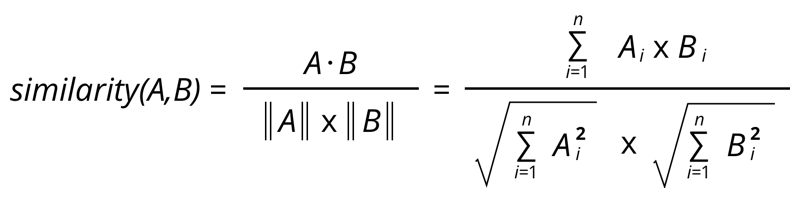

In [45]:
from numpy import dot
from numpy.linalg import norm
A = [1,2]
B = [2,2]
cos_sim = dot(A,B) / (norm(A)*norm(B))
print(cos_sim)

0.9486832980505138


In [46]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Vector hóa nội dung
vectorizer = TfidfVectorizer(analyzer='word', stop_words=stop_words)
tfidf_matrix = vectorizer.fit_transform(df['Content'])

# Tính toán độ tương đồng
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [47]:
df_show = pd.DataFrame(cosine_sim)
df_show

,0,1,2,3,4,5,6,7,8,9,...,676,677,678,679,680,681,682,683,684,685
0,1.000000,0.070367,0.098546,0.068710,0.117180,0.130704,0.128826,0.168297,0.128856,0.165961,...,0.204372,0.084647,0.078123,0.073878,0.129065,0.079122,0.108612,0.102200,0.118890,0.066998
1,0.070367,1.000000,0.358971,0.155494,0.191220,0.267143,0.192920,0.242058,0.172324,0.068868,...,0.127391,0.146830,0.103954,0.134382,0.106571,0.048500,0.149045,0.209346,0.168960,0.142015
2,0.098546,0.358971,1.000000,0.188221,0.253459,0.309739,0.204259,0.339265,0.222691,0.103884,...,0.169682,0.197707,0.148997,0.212403,0.138167,0.068508,0.227950,0.242628,0.220158,0.189647
3,0.068710,0.155494,0.188221,1.000000,0.137617,0.196163,0.123022,0.165530,0.134574,0.063051,...,0.105883,0.112095,0.117368,0.240006,0.094745,0.056015,0.136411,0.137087,0.133362,0.107495
4,0.117180,0.191220,0.253459,0.137617,1.000000,0.275283,0.246137,0.274147,0.234894,0.126765,...,0.207022,0.208010,0.191889,0.223124,0.188315,0.078247,0.260760,0.276473,0.287957,0.206772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,0.079122,0.048500,0.068508,0.056015,0.078247,0.081593,0.076775,0.076835,0.071399,0.049289,...,0.080171,0.062228,0.056139,0.050869,0.063616,1.000000,0.077150,0.072264,0.077185,0.052771
682,0.108612,0.149045,0.227950,0.136411,0.260760,0.246418,0.219251,0.199649,0.162940,0.089083,...,0.175172,0.164595,0.128925,0.191592,0.159641,0.077150,1.000000,0.175683,0.351698,0.140350
683,0.102200,0.209346,0.242628,0.137087,0.276473,0.238669,0.181046,0.243916,0.247968,0.105370,...,0.202744,0.174529,0.184517,0.173283,0.126982,0.072264,0.175683,1.000000,0.208817,0.177441
684,0.118890,0.168960,0.220158,0.133362,0.287957,0.235153,0.215345,0.223003,0.196649,0.111092,...,0.197532,0.190508,0.174318,0.167930,0.164200,0.077185,0.351698,0.208817,1.000000,0.147984


In [48]:
# Hàm đề xuất sản phẩm
# # với mỗi sản phẩm, lấy nums sản phẩm tương quan nhất
def get_recommendations(sp_id, cosine_sim=cosine_sim, nums=5):
    idx = df.index[df['ma_san_pham'] == sp_id][0]
    print(idx)
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[0:nums+1]  # Lấy 3 sản phẩm tương tự nhất
    sp_indices = [i[0] for i in sim_scores]
    return df.iloc[sp_indices]

In [1]:
# Nhập mã sản phẩm từ terminal
product_code = int(input('Khách hàng vui lòng nhập mã sản phẩm: '))

start_time = time.time()

try:
    recommendations = get_recommendations(product_code)
    print(recommendations)
except IndexError:
    print(f"Mã sản phẩm {product_code} không tồn tại trong dữ liệu.")

end_time = time.time()
elapsed_time_cosine = end_time - start_time

print(f"Time taken to execute the code: {elapsed_time_cosine:.3f} seconds")


ValueError: invalid literal for int() with base 10: ''

In [ ]:
print(f"Time taken to execute the code: {elapsed_time_cosine:.3f} seconds")

Time taken to execute the code: 0.002 seconds
